In [101]:
import numpy as np
import os
import dask.array as da
import glob
from dask import array as da
import os
import numpy as np
def read_im(path, return_pos=False):
    dirname = os.path.dirname(path)
    fov = os.path.basename(path).split('_')[-1].split('.')[0]
    file_ = os.path.join(dirname, fov, 'data')
    
    xml_file = os.path.splitext(path)[0] + '.xml'
    txt = open(xml_file, 'r').read()
    tag = '<stage_position type="custom">'
    x, y = eval(txt.split(tag)[-1].split('</')[0])
    if r'.fast.zarr' in txt:
        image = da.from_zarr(path)
        ncols = 5
        image = image.reshape([-1,ncols,image.shape[-2],image.shape[-1]])
        image = image.swapaxes(0,1)
        if image.dtype == np.uint8:
            image = image.astype(np.uint16) 
            image = image*image
            image = da.array([image[1]+image[2],image[3],image[4],image[0]])
    else:
        image = da.from_zarr(file_)[1:]
    
        shape = image.shape
        tag = '<z_offsets type="string">'
        zstack = txt.split(tag)[-1].split('</')[0]
    
        nchannels = int(zstack.split(':')[-1])
        nzs = (shape[0] // nchannels) * nchannels
        image = image[:nzs].reshape([shape[0] // nchannels, nchannels, shape[-2], shape[-1]])
        image = image.swapaxes(0, 1)
        if image.dtype == np.uint8:
            image = image.astype(np.uint16) 
            image = image*image
    
    if return_pos:
        return image, x, y
    return image
    
def get_pos(path):
    xml_file = os.path.splitext(path)[0] + '.xml'
    txt = open(xml_file, 'r').read()
    tag = '<stage_position type="custom">'
    x, y = eval(txt.split(tag)[-1].split('</')[0])
    return x,y

def get_im_from_Xh(Xh,resc=5):
    X = np.round(Xh[:,:3]/resc).astype(int)
    sz = np.max(X,axis=0)
    imf = np.zeros(sz+1,dtype=np.float32)
    imf[tuple(X.T)]=1
    return imf
from scipy.spatial import KDTree
def get_Xtzxy(X,X_ref,tzxy0,resc,target=3):
    tzxy = tzxy0
    Npts =0
    for dist_th in np.linspace(resc,target,5):
        XT = X-tzxy
        ds,inds = KDTree(X_ref).query(XT,workers=20)
        keep = ds<dist_th
        X_ref_ = X_ref[inds[keep]]
        X_ = X[keep]
        tzxy = np.mean(X_-X_ref_,axis=0)
        #print(tzxy)
        Npts = np.sum(keep)
    return tzxy,Npts
def get_best_translation_points(X,X_ref,resc=10,target=1,constr=None,return_counts=False):
    XFF = np.concatenate([X,X_ref])
    X = X-np.min(XFF,axis=0)
    X_ref = X_ref-np.min(XFF,axis=0)
    if constr is not None:
        Xm = np.max([np.min(X,axis=0),np.min(X_ref,axis=0)],axis=0)-constr
        XM = np.min([np.max(X,axis=0),np.max(X_ref,axis=0)],axis=0)+constr
        keep = np.all((X<=XM)&(X>=Xm),axis=-1)
        X = X[keep]
        keep = np.all((X_ref<=XM)&(X_ref>=Xm),axis=-1)
        X_ref = X_ref[keep]
        XFF = np.concatenate([X,X_ref])
        X = X-np.min(XFF,axis=0)
        X_ref = X_ref-np.min(XFF,axis=0)
    
    im = get_im_from_Xh(X,resc=resc)
    im_ref = get_im_from_Xh(X_ref,resc=resc)
    
    from scipy.signal import fftconvolve
    im_cor = fftconvolve(im,im_ref[::-1,::-1,::-1])
    #plt.imshow(np.max(im_cor,0))
    tzxy = np.array(np.unravel_index(np.argmax(im_cor),im_cor.shape))-im_ref.shape+1
    tzxy = tzxy*resc
    Npts=0
    tzxy,Npts = get_Xtzxy(X,X_ref,tzxy,resc=resc,target=target)
    if return_counts:
        return tzxy,Npts
    return tzxy
def calc_color_matrix(x,y,order=2):
    """This gives a quadratic color transformation (in matrix form)
    x is Nx3 vector of positions in the reference channel (typically cy5)
    y is the Nx3 vector of positions in another channel (i.e. cy7)
    return m_ a 3x7 matrix which when multipled with x,x**2,1 returns y-x
    This m_ is indended to be used with apply_colorcor
    """ 
    x_ = np.array(y)# ref zxy
    y_ = np.array(x)-x_# dif zxy
    # get a list of exponents
    exps = []
    for p in range(order+1):
        for i in range(p+1):
            for j in range(p+1):
                if i+j<=p:
                    exps.append([i,j,p-i-j])
    # construct A matrix
    A = np.zeros([len(x_),len(exps)])
    for iA,(ix,iy,iz) in enumerate(exps):
        s = (x_[:,0]**ix*x_[:,1]**iy*x_[:,2]**iz)
        A[:,iA]=s
    m_ = [np.linalg.lstsq(A, y_[:,iy])[0] for iy in range(len(x_[0]))]
    m_=np.array(m_)
    return m_
def apply_colorcor(x,m=None):
    """This applies chromatic abberation correction to order 2
    x is a Nx3 vector of positions (typically 750(-->647))
    m is a matrix computed by function calc_color_matrix
    y is the corrected vector in another channel"""
    if m is None:
        return x
    exps = []
    order_max=10
    for p in range(order_max+1):
        for i in range(p+1):
            for j in range(p+1):
                if i+j<=p:
                    exps.append([i,j,p-i-j])
    #find the order
    mx,my = m.shape
    order = int((my-1)/mx)
    assert(my<len(exps))
    x_ = np.array(x)
    # construct A matrix
    exps = exps[:my]
    A = np.zeros([len(x_),len(exps)])
    for iA,(ix,iy,iz) in enumerate(exps):
        s = (x_[:,0]**ix*x_[:,1]**iy*x_[:,2]**iz)
        A[:,iA]=s
    diff = [np.dot(A,m_) for m_ in m]
    return x_+np.array(diff).T
def apply_transf(X1,Trans,resc = (4,10,10)):
    X1R = (X1//resc).astype(int)
    for i in np.arange(len(Trans.shape)-1):
        X1R[:,i] = np.clip(X1R[:,i],0,Trans.shape[i]-1)
    return X1+Trans[tuple(X1R.T)]
def calc_trasnf(X2,X1,szM = (40,2800,2800),resc = (4,10,10)):
    Trans = np.zeros(list(np.array(szM)//resc)+[3])
    Neles = np.zeros(list(np.array(szM)//resc))
    X1R = (X1//resc).astype(int)
    for i in np.arange(len(Trans.shape)-1):
        X1R[:,i] = np.clip(X1R[:,i],0,Trans.shape[i]-1)
    np.add.at(Trans,tuple(X1R.T),X2-X1)
    np.add.at(Neles,tuple(X1R.T),1)
    TransF = Trans/Neles[...,np.newaxis]
    
    Xbad = np.array(np.where(np.isnan(TransF[...,0]))).T
    Xgood= np.array(np.where(~np.isnan(TransF[...,0]))).T
    dd,ii = KDTree(Xgood).query(Xbad)
    TransF[tuple(Xbad.T)]=TransF[tuple(Xgood[ii].T)]
    return TransF
def get_tzxy_plus_minus(obj_Xh_plus,obj_Xh_minus,obj_ref_Xh_plus,obj_ref_Xh_minus,resc=5,th=0):
    tzxyf,tzxy_plus,tzxy_minus,N_plus,N_minus = np.array([0,0,0]),np.array([0,0,0]),np.array([0,0,0]),0,0
    if (len(obj_Xh_plus)>0) and (len(obj_ref_Xh_plus)>0):
        X = obj_Xh_plus[obj_Xh_plus[:,-1]>th][:,:3]
        X_ref = obj_ref_Xh_plus[obj_ref_Xh_plus[:,-1]>th][:,:3]#obj_ref_Xh_plus[:,:3]
        tzxy_plus,N_plus = get_best_translation_points(X,X_ref,resc=resc,return_counts=True)
    if (len(obj_Xh_minus)>0) and (len(obj_ref_Xh_minus)>0):
        X = obj_Xh_minus[obj_Xh_minus[:,-1]>th][:,:3]
        X_ref = obj_ref_Xh_minus[obj_ref_Xh_minus[:,-1]>th][:,:3]#obj_ref_Xh_plus[:,:3]
        tzxy_minus,N_minus = get_best_translation_points(X,X_ref,resc=resc,return_counts=True)
    if np.max(np.abs(tzxy_minus-tzxy_plus))<=2:
        tzxyf = -(tzxy_plus*N_plus+tzxy_minus*N_minus)/(N_plus+N_minus)
    else:
        tzxyf = -[tzxy_plus,tzxy_minus][np.argmax([N_plus,N_minus])]
    return [tzxyf,tzxy_plus,tzxy_minus,N_plus,N_minus]

def get_best_translation_pointsT(fov,htag,htagref,save_folder,save_folder_ref,set_='',resc=5,th=0,MA=None):
    fl_feats = rf'{save_folder}\{fov}--{htag}--dapiFeatures.npz'
    fl_feats_ref = rf'{save_folder_ref}\{fov}--{htagref}--dapiFeatures.npz'
    obj_Xh_plus,obj_Xh_minus = np.load(fl_feats)['Xh_plus'],np.load(fl_feats)['Xh_minus']
    obj_ref_Xh_plus,obj_ref_Xh_minus = np.load(fl_feats_ref)['Xh_plus'],np.load(fl_feats_ref)['Xh_minus']
    obj_ref_Xh_plus[:,:3] = apply_colorcor(obj_ref_Xh_plus[:,:3],MA)
    obj_ref_Xh_minus[:,:3] = apply_colorcor(obj_ref_Xh_minus[:,:3],MA)
    obj_Xh_plus[:,:3] = apply_colorcor(obj_Xh_plus[:,:3],MA)
    obj_Xh_minus[:,:3] = apply_colorcor(obj_Xh_minus[:,:3],MA)
    
    
    tzxyf,tzxy_plus,tzxy_minus,N_plus,N_minus = get_tzxy_plus_minus(obj_Xh_plus,obj_Xh_minus,obj_ref_Xh_plus,obj_ref_Xh_minus,resc=resc,th=th)
    return tzxyf,tzxy_plus,tzxy_minus,N_plus,N_minus
import torch
def get_icodesV3(dec,nmin_bits=3,iH=-3,save=False,make_unique=False):
    import time
    start = time.time()
    lens = dec.lens
    res_unfolder = dec.res_unfolder
    Mlen = np.max(lens)
    print("Calculating indexes within cluster...")
    res_is = np.tile(np.arange(Mlen), len(lens))
    res_is = res_is[res_is < np.repeat(lens, Mlen)]
    print("Calculating index of molecule...")
    ires = np.repeat(np.arange(len(lens)), lens)
    #r0 = np.array([r[0] for r in res for r_ in r])
    print("Calculating index of first molecule...")
    r0i = np.concatenate([[0],np.cumsum(lens)])[:-1]
    r0 = res_unfolder[np.repeat(r0i, lens)]
    print("Total time unfolded molecules:",time.time()-start)
    
    ### torch
    ires = torch.from_numpy(ires.astype(np.int64))
    res_unfolder = torch.from_numpy(res_unfolder.astype(np.int64))
    res_is = torch.from_numpy(res_is.astype(np.int64))
    
    import time
    start = time.time()
    print("Computing score...")
    scoreF = torch.from_numpy(dec.XH[:,iH])[res_unfolder]
    print("Total time computing score:",time.time()-start)
    
    
    ### organize molecules in blocks for each cluster
    def get_asort_scores():
        val = torch.max(scoreF)+2
        scoreClu = torch.zeros([len(lens),Mlen],dtype=torch.float64)+val
        scoreClu[ires,res_is]=scoreF
        asort = scoreClu.argsort(-1)
        scoreClu = torch.gather(scoreClu,dim=-1,index=asort)
        scoresF2 = scoreClu[scoreClu<val-1]
        return asort,scoresF2
    def get_reorder(x,val=-1):
        if type(x) is not torch.Tensor:
            x = torch.from_numpy(np.array(x))
        xClu = torch.zeros([len(lens),Mlen],dtype=x.dtype)+val
        xClu[ires,res_is] = x
        xClu = torch.gather(xClu,dim=-1,index=asort)
        xf = xClu[xClu>val]
        return xf
    
    
    import time
    start = time.time()
    print("Computing sorting...")
    asort,scoresF2 = get_asort_scores()
    res_unfolder2 = get_reorder(res_unfolder,val=-1)
    del asort
    del scoreF
    print("Total time sorting molecules by score:",time.time()-start)
    
    
    
    import time
    start = time.time()
    print("Finding best bits per molecules...")
    
    Rs = dec.XH[:,-1].astype(np.int64)
    Rs = torch.from_numpy(Rs)
    Rs_U = Rs[res_unfolder2]
    nregs,nbits = dec.codes_01.shape
    score_bits = torch.zeros([len(lens),nbits],dtype=scoresF2.dtype)-1
    score_bits[ires,Rs_U]=scoresF2
    
    
    codes_lib = torch.from_numpy(np.array(dec.codes__))
    
    
    codes_lib_01 = torch.zeros([len(codes_lib),nbits],dtype=score_bits.dtype)
    for icd,cd in enumerate(codes_lib):
        codes_lib_01[icd,cd]=1
    codes_lib_01 = codes_lib_01/torch.norm(codes_lib_01,dim=-1)[:,np.newaxis]
    print("Finding best code...")
    batch = 10000
    icodes_best = torch.zeros(len(score_bits),dtype=torch.int64)
    dists_best = torch.zeros(len(score_bits),dtype=torch.float32)
    from tqdm import tqdm
    for i in tqdm(range((len(score_bits)//batch)+1)):
        score_bits_ = score_bits[i*batch:(i+1)*batch]
        if len(score_bits_)>0:
            score_bits__ = score_bits_.clone()
            score_bits__[score_bits__==-1]=0
            score_bits__ = score_bits__/torch.norm(score_bits__,dim=-1)[:,np.newaxis]
            Mul = torch.matmul(score_bits__,codes_lib_01.T)
            max_ = torch.max(Mul,dim=-1)
            icodes_best[i*batch:(i+1)*batch] = max_.indices
            dists_best[i*batch:(i+1)*batch] = 2-2*max_.values
    
    
    keep_all_bits = torch.sum(score_bits.gather(1,codes_lib[icodes_best])>=0,-1)>=nmin_bits
    dists_best_ = dists_best[keep_all_bits]
    score_bits = score_bits[keep_all_bits]
    icodes_best_ = icodes_best[keep_all_bits]
    icodesN=icodes_best_
    
    indexMols_ = torch.zeros([len(lens),nbits],dtype=res_unfolder2.dtype)-1
    indexMols_[ires,Rs_U]=res_unfolder2
    indexMols_ = indexMols_[keep_all_bits]
    indexMols_ = indexMols_.gather(1,codes_lib[icodes_best_])
    
    # make unique
    dec.dist_best = dists_best_.numpy()
    if make_unique:
        indexMols_,rinvMols = get_unique_ordered(indexMols_)
        icodesN = icodesN[rinvMols]
        dec.dist_best = dists_best_[rinvMols].numpy()
    XH = torch.from_numpy(dec.XH)
    XH_pruned = XH[indexMols_]
    XH_pruned[indexMols_==-1]=np.nan
    
    
    dec.XH_pruned=XH_pruned.numpy()
    dec.icodesN=icodesN.numpy()
    if save:
        np.savez_compressed(dec.decoded_fl,XH_pruned=dec.XH_pruned,icodesN=dec.icodesN,gns_names = np.array(dec.gns_names),dist_best=dec.dist_best)
    print("Total time best bits per molecule:",time.time()-start)
def get_XH_singleFOV(self,fov,set_,ncols=3,nbits=16,th_h=0,tag_keep='MER',medH_fl=None,color_fl=None):
    self.set_ = set_
    save_folder = self.save_folder
    drift_fl = save_folder+os.sep+'driftNew_'+fov.split('.')[0]+'--'+set_+'.pkl'
    if os.path.exists(drift_fl):
        drifts,all_flds,fov,fl_ref = pickle.load(open(drift_fl,'rb'))
        self.drifts,self.all_flds,self.fov,self.fl_ref = drifts,all_flds,fov,fl_ref
    else:
        drift_fl = save_folder+os.sep+'driftNew_'+fov.split('.')[0]+'--'+set_+'.pkl'
        drifts,all_flds,fov = pickle.load(open(drift_fl,'rb'))
        self.drifts,self.all_flds,self.fov = drifts,all_flds,fov

    XH = []
    for iH in tqdm(np.arange(len(all_flds))):
        fld = all_flds[iH]
        if tag_keep in os.path.basename(fld):
            for icol in range(ncols):
                tag = os.path.basename(fld)
                save_fl = save_folder+os.sep+fov.split('.')[0]+'--'+tag+'--col'+str(icol)+'__Xhfits.npy.npz'
                if not os.path.exists(save_fl):save_fl = save_fl.replace('.npy','')
                Xh = np.load(save_fl,allow_pickle=True)['Xh']
                
                        
                ih = get_iH(fld) # get bit
                
                bit = (ih-1)*ncols+icol
                print(Xh.shape)
                if len(Xh.shape):
                    if medH_fl is not None:
                        medHs = np.load(medH_fl)['medHs']
                        Xh[:,-1]=Xh[:,-1]/medHs[bit]
                if len(Xh.shape):
                    if len(Xh):
                        Xh = Xh[Xh[:,-1]>th_h]
                    if len(Xh):
                        
                        icolR = np.array([[icol,bit]]*len(Xh))

                        if color_fl is not None:
                            ms = np.load(color_fl,allow_pickle=True)
                            Xh[:,[0,1,2]] = apply_colorcor(Xh[:,[0,1,2]],ms[icol])
                        Xh[:,:3]+=tzxy# drift correction
                        XH_ = np.concatenate([Xh,icolR],axis=-1)
                        XH.extend(XH_)
    self.XH = np.array(XH)
def get_fov(fl):
    return os.path.basename(fl).split('--')[0].replace('.zarr','')
def get_set(fov):
    return '_set'+fov.split('zscan')[-1].split('_')[0]
from scipy.spatial import KDTree
def get_intersV2(self,nmin_bits=3,dinstance_th=2):
    """Get an initial intersection of points and save in self.res"""

    XH = self.XH
    Xs = XH[:,:3]
    Ts = KDTree(Xs)
    res = Ts.query_ball_point(Xs,dinstance_th,workers=20)
    print("Calculating lengths of clusters...")
    lens = np.array(list(map(len,res)))
    Mlen = np.max(lens)
    print("Unfolding indexes...")
    res_unfolder = np.concatenate(res)
    
    self.res_unfolder=res_unfolder
    self.lens=lens
    
    lens =self.lens
    self.res_unfolder = self.res_unfolder[np.repeat(lens, lens)>=nmin_bits]
    self.lens = self.lens[lens>=nmin_bits]
def load_library(self,lib_fl = r'Z:\DCBBL1_3_2_2023\MERFISH_Analysis\codebook_0_New_DCBB-300_MERFISH_encoding_2_21_2023.csv',nblanks=-1):
        code_txt = np.array([ln.replace('\n','').split(',') for ln in open(lib_fl,'r') if ',' in ln])
        gns = code_txt[1:,0]
        code_01 = code_txt[1:,2:].astype(int)
        codes = np.array([np.where(cd)[0] for cd in code_01])
        codes_ = [list(np.sort(cd)) for cd in codes]
        nbits = np.max(codes)+1

        codes__ = codes_
        gns__ = list(gns)
        if nblanks>=0:
            ### get extrablanks
            from itertools import combinations
            X_codes = np.array((list(combinations(range(nbits),4))))
            X_code_01 = []
            for cd in X_codes:
                l_ = np.zeros(nbits)
                l_[cd] = 1
                X_code_01.append(l_)
            X_code_01 = np.array(X_code_01,dtype=int)
            from scipy.spatial.distance import cdist
            eblanks = np.where(np.min(cdist(code_01,X_code_01,metric='hamming'),0)>=4/float(nbits))[0]
            codes__ = codes_ + [list(e)for e in X_codes[eblanks]]
            gns__ = list(gns)+ ['blanke'+str(ign+1).zfill(4) for ign in range(len(eblanks))]
        
        bad_gns = np.array(['blank' in e for e in gns__])
        good_gns = np.where(~bad_gns)[0]
        bad_gns = np.where(bad_gns)[0]

        
        
        self.lib_fl = lib_fl ### name of coding library
        self.nbits = nbits ### number of bits
        self.gns_names = gns__  ### names of genes and blank codes
        self.bad_gns = bad_gns ### indices of the blank codes
        self.good_gns = good_gns ### indices of the good gene codes
        self.codes__ = codes__ ### final extended codes of form [bit1,bit2,bit3,bit4]
        self.codes_01 = code_01
        if nblanks>=0:
            self.codes_01 = np.concatenate([code_01,X_code_01[eblanks]],axis=0) ### final extended codes of form [0,1,0,0,1...]
        
        dic_bit_to_code = {}
        for icd,cd in enumerate(self.codes__): 
            for bit in cd:
                if bit not in dic_bit_to_code: dic_bit_to_code[bit]=[]
                dic_bit_to_code[bit].append(icd)
        self.dic_bit_to_code = dic_bit_to_code  ### a dictinary in which each bit is mapped to the inde of a code
def get_score(dec):
    H = np.nanmedian(dec.XH_pruned[...,-3],axis=1)
    n1bits = dec.XH_pruned.shape[1]
    from itertools import combinations
    combs = np.array(list(combinations(np.arange(n1bits),2)))
    X = dec.XH_pruned[:,:,:3]
    D = np.nanmean(np.linalg.norm(X[:,combs][:,:,0]-X[:,combs][:,:,1],axis=-1),axis=1)
    db = dec.dist_best
    score = np.array([H,-D,-db]).T
    #score = np.sort(score,axis=1)
    #score_ref = np.sort(score,axis=0)
    dec.score = score
    return score
def set_scoreA(dec):
    score_ref = dec.score_ref
    score = dec.score
    from scipy.spatial import KDTree
    scoreA = np.zeros(len(score))
    for iS in range(score.shape[-1]):
        dist_,inds_ = KDTree(score_ref[:,[iS]]).query(score[:,[iS]],workers=20)
        scoreA+=np.log((inds_+1))-np.log(len(score_ref))
    dec.scoreA = scoreA
from tqdm import tqdm

In [9]:
# ### map positions of all fovs
# all_fls = glob.glob(r'Z:\MERFISHp\12_16_2025_BigSlideTest\H1_MER*\*.zarr')
# from tqdm import tqdm
# import pickle
# dic_pos = {get_fov(fl):get_pos(fl)for fl in tqdm(all_fls)}
# pickle.dump(dic_pos,open(r'Z:\MERFISHp\12_16_2025_BigSlideTest\dic_pos.pkl','wb'))

In [16]:
class dummy():
    def __init__(self):
        pass

In [17]:
def get_XH_full(dec,fov='Conv_zscan1__044',ncols=3,sz = [40,2800,2800],pix_size = 0.1083333,th_cor=0.25,
               save_folders = [r'Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits','Z:\MERFISHp\12_16_2025_BigSlideTestV2\mermake_fits'],color_fl  = None,medH_fl = None):
    dec.ncols = ncols
    dec.sz = sz
    dec.pix_size=pix_size
    
    set_ = get_set(fov)
    dec.set_ = set_
    
    
    dec.save_folders = save_folders
    htags = [f'H{iH+1}_MER{set_}' for iH in np.arange(9)]
    dic_pos = pickle.load(open(r'Z:\MERFISHp\12_16_2025_BigSlideTest\dic_pos.pkl','rb'))
    dec.dic_pos = dic_pos
    fovs = np.array(list(dic_pos.keys()))
    pos  = np.array([dic_pos[fv]for fv in fovs])
    ifov = list(fovs).index(fov)
    
    dists_pix = np.linalg.norm(np.abs((pos[ifov]-pos)/pix_size),axis=-1)
    allneigh = np.where(dists_pix<np.sqrt(2)*sz[-1]*1.25)[0]
    allneigh = allneigh[np.argsort(dists_pix[allneigh])]
    fovs_neigh = fovs[allneigh]
    dec.fovs = fovs
    dec.allneigh = allneigh
    dec.pos = pos
    XH = []
    for iH,htag in enumerate(tqdm(htags)):
        for icol in np.arange(ncols):
            Xhs,Xprev,posT_fovs= [],[],[]
            tfov=0
            for ifv in allneigh:
                fv = fovs[ifv]
                for save_folder in save_folders:
                    fit_fl = save_folder+os.sep+fv+'--'+htag+'--col'+str(icol)+'__Xhfits.npz'
                    ### deal with 
                    X_prev = []
                    if os.path.exists(fit_fl):
                        Xh = np.load(fit_fl,allow_pickle=True)['Xh']
                        X = []
                        if len(Xh.shape):
                            if len(Xh)>0:
                                X = Xh[Xh[:,-4]>0.5][:,:3]
                        if len(X)<len(X_prev):
                            X = X_prev
                            Xh = Xh_prev
                            SAVE_FOLDER = save_folder_prev
                        else:
                            X_prev = X
                            Xh_prev = Xh
                            SAVE_FOLDER = save_folder_prev = save_folder
                    
                if (iH==0) and (ifv==allneigh[0]):
                    save_folder_ref = SAVE_FOLDER
                    htagref = htag
                if len(Xh.shape):
                    if len(Xh)>0:
                        Xh = Xh[Xh[:,-2]>th_cor]
                        Xh[:,3] = tfov
                        if color_fl is not None:
                            ms = np.load(color_fl,allow_pickle=True)
                            Xh[:,:3] = apply_colorcor(Xh[:,:3],ms[icol])
                        X = Xh[:,:3]
                        MA = np.load(r'Z:\MERFISHp\12_16_2025_BigSlideTest\MasterColor1TransformNew.npy')
                        X = apply_colorcor(X,MA)
                        Xh[:,:3]=X
                        X = X[Xh[:,-4]>0.5]
                    
                        pT = pos[allneigh[0]]
                        px,py = (pos[ifv]-pT)/pix_size
                        X = X+[0,px,py]
                        tzxy = np.array([0,0,0])
                        if len(Xprev)>0:
                            Xall = np.concatenate(Xprev)
                            try:
                                tzxy = get_best_translation_points(X,Xall,resc=5,target=3,constr=50,return_counts=False)
                                X = X-tzxy
                            except:
                                pass
                        T = [0,px,py]-tzxy
                        Xh[:,:3]+=T
                        Xprev.append(X)
                        Xhs.append(Xh)
                        posT_fovs.append(T+np.array(sz)/2)
                        tfov+=1
            Xhs = np.concatenate(Xhs)
            if len(Xhs)>0:
                XA = Xhs[:,:3]
                iFOV = Xhs[:,3].astype(int)
                dd,ii = KDTree(posT_fovs).query(XA,p=np.inf,workers=20)
                Xhs = Xhs[ii==iFOV]
                Xh = Xhs
                if len(Xh)>0:
                    Xh = Xh[np.all((Xh[:,1:3]<dec.sz[-2:])&(Xh[:,1:3]>0),axis=-1)]
                    ### Calculate drift
                    if len(Xh)>0:
                        tzxyf,tzxy_plus,tzxy_minus,N_plus,N_minus = get_best_translation_pointsT(fov,htag,htagref,SAVE_FOLDER,save_folder_ref,set_=set_,resc=5,th=0,MA=MA)
                        print(htag,htagref,SAVE_FOLDER,save_folder_ref)
                        print("Drift:",tzxyf,tzxy_plus,tzxy_minus,N_plus,N_minus)
                        Xh[:,:3]=Xh[:,:3]+tzxyf# drift correction
                        
                        bit = iH*ncols+icol
                        if medH_fl is not None:
                            medHs = np.load(medH_fl)['medHs']
                            Xh[:,-1]=Xh[:,-1]/medHs[bit]
             
                        icolR = np.array([[icol,bit]]*len(Xh))
                        XH_ = np.concatenate([Xh,icolR],axis=-1)
                        XH.append(XH_)
        
    XH = np.concatenate(XH)
    dec.XH = XH

In [172]:
def get_XH_singleFOV(self,fov,ncols=3,th_cor=0.25,tag_keep='MER',medH_fl=None,color_fl=None):
    set_ = self.set_ = get_set(fov)
    save_folder = self.save_folder
    all_flds = htags = [f'H{iH+1}_MER{set_}' for iH in np.arange(9)]
    htagref = all_flds[0]
    XH = []
    for iH in tqdm(np.arange(len(all_flds))):
        fld = all_flds[iH]
        if tag_keep in os.path.basename(fld):
            for icol in range(ncols):
                htag = os.path.basename(fld)
                save_fl = save_folder+os.sep+fov.split('.')[0]+'--'+htag+'--col'+str(icol)+'__Xhfits.npy.npz'
                if not os.path.exists(save_fl):save_fl = save_fl.replace('.npy','')
                Xh = np.load(save_fl,allow_pickle=True)['Xh']
                def get_iH(fld): return int(os.path.basename(fld).split('_')[0][1:])
                ih = get_iH(fld) # get bit
                
                bit = (ih-1)*ncols+icol
                print(Xh.shape)
                if len(Xh.shape):
                    if medH_fl is not None:
                        medHs = np.load(medH_fl)['medHs']
                        Xh[:,-1]=Xh[:,-1]/medHs[bit]
                if len(Xh.shape):
                    if len(Xh):
                        Xh = Xh[Xh[:,-2]>th_cor]
                    if len(Xh):
                        
                        icolR = np.array([[icol,bit]]*len(Xh))
                        master_trasnf = r'Z:\MERFISHp\12_16_2025_BigSlideTest\MasterColor1TransformNew.npy'
                        MA = np.load(master_trasnf,allow_pickle=True)
                        #MA=None
                        Xh[:,:3] = apply_colorcor(Xh[:,:3],MA)#[:,1:]
                        
                        if color_fl is not None:
                            ms = np.load(color_fl,allow_pickle=True)
                            Xh[:,:3] = apply_colorcor(Xh[:,:3],ms[icol])
                        
                        save_folder_ref = save_folder
                        tzxyf,tzxy_plus,tzxy_minus,N_plus,N_minus = get_best_translation_pointsT(fov,htag,htagref,save_folder,save_folder_ref,
                                                                                                 set_=set_,resc=5,th=0,MA=MA)
                        print(htag,htagref,save_folder,save_folder_ref)
                        print("Drift:",tzxyf,tzxy_plus,tzxy_minus,N_plus,N_minus)
                        Xh[:,:3]=Xh[:,:3]+tzxyf# drift correction
                        
                        XH_ = np.concatenate([Xh,icolR],axis=-1)
                        XH.extend(XH_)
    self.XH = np.array(XH)

In [128]:
master_trasnf = r'Z:\MERFISHp\12_16_2025_BigSlideTest\MasterColor1TransformNew.npy'
MA = np.load(master_trasnf,allow_pickle=True)

In [132]:
Xtc = []
for z in np.linspace(0,40-1,20):
    for x in np.linspace(0,2800-1,200):
        for y in np.linspace(0,2800-1,200):
            Xtc.append([z,x,y])
Xtc = np.array(Xtc)
Xtt = apply_colorcor(Xtc,MA)
V = napari.Viewer()
V.add_points(Xtc[:,1:],face_color='r',border_width=0,size=2)
V.add_points(Xtt[:,1:],face_color='g',border_width=0,size=2)

<Points layer 'Points [1]' at 0x1cd87a46260>

In [256]:

dec=dummy()
dec.save_folder = r'Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits'
get_XH_singleFOV(dec,fov='Conv_zscan1__013',ncols=3,th_cor=0.25,tag_keep='MER',medH_fl=r'Z:\MERFISHp\12_16_2025_BigSlideTest\medHs.npz',
                 color_fl=r'Z:\MERFISHp\12_16_2025_BigSlideTest\3color_coorection_Mammoth_afterGlobalFinal.pkl')

  0%|                                                                                            | 0/9 [00:00<?, ?it/s]

(584973, 8)
H1_MER_set1 H1_MER_set1 Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits
Drift: [-0. -0. -0.] [0. 0. 0.] [0. 0. 0.] 2505 1492
(361321, 8)
H1_MER_set1 H1_MER_set1 Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits
Drift: [-0. -0. -0.] [0. 0. 0.] [0. 0. 0.] 2505 1492
(333152, 8)


 11%|█████████▎                                                                          | 1/9 [00:04<00:37,  4.74s/it]

H1_MER_set1 H1_MER_set1 Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits
Drift: [-0. -0. -0.] [0. 0. 0.] [0. 0. 0.] 2505 1492
(254096, 8)
H2_MER_set1 H1_MER_set1 Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits
Drift: [ 0.7712361   2.73558578 79.54546711] [ -0.77242833  -2.7444813  -79.56023   ] [ -0.7682912  -2.713613  -79.50901  ] 867 351
(429989, 8)
H2_MER_set1 H1_MER_set1 Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits
Drift: [ 0.7712361   2.73558578 79.54546711] [ -0.77242833  -2.7444813  -79.56023   ] [ -0.7682912  -2.713613  -79.50901  ] 867 351
(504211, 8)


 22%|██████████████████▋                                                                 | 2/9 [00:09<00:32,  4.67s/it]

H2_MER_set1 H1_MER_set1 Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits
Drift: [ 0.7712361   2.73558578 79.54546711] [ -0.77242833  -2.7444813  -79.56023   ] [ -0.7682912  -2.713613  -79.50901  ] 867 351
(559566, 8)
H3_MER_set1 H1_MER_set1 Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits
Drift: [ -0.42982103   2.91706663 139.77146771] [   0.41363713   -2.9189947  -139.77695   ] [   0.47429997   -2.9117677  -139.75641   ] 830 302
(323597, 8)
H3_MER_set1 H1_MER_set1 Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits
Drift: [ -0.42982103   2.91706663 139.77146771] [   0.41363713   -2.9189947  -139.77695   ] [   0.47429997   -2.9117677  -139.75641   ] 830 302
(404644, 8)


 33%|████████████████████████████                                                        | 3/9 [00:14<00:28,  4.76s/it]

H3_MER_set1 H1_MER_set1 Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits
Drift: [ -0.42982103   2.91706663 139.77146771] [   0.41363713   -2.9189947  -139.77695   ] [   0.47429997   -2.9117677  -139.75641   ] 830 302
(503080, 8)
H4_MER_set1 H1_MER_set1 Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits
Drift: [ -0.45983366   5.23646602 190.24875324] [   0.4468539   -5.227935  -190.26619  ] [   0.49461755   -5.2593284  -190.20203   ] 745 278
(337194, 8)
H4_MER_set1 H1_MER_set1 Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits
Drift: [ -0.45983366   5.23646602 190.24875324] [   0.4468539   -5.227935  -190.26619  ] [   0.49461755   -5.2593284  -190.20203   ] 745 278
(396842, 8)


 44%|█████████████████████████████████████▎                                              | 4/9 [00:19<00:24,  4.81s/it]

H4_MER_set1 H1_MER_set1 Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits
Drift: [ -0.45983366   5.23646602 190.24875324] [   0.4468539   -5.227935  -190.26619  ] [   0.49461755   -5.2593284  -190.20203   ] 745 278
(414956, 8)
H5_MER_set1 H1_MER_set1 Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits
Drift: [  1.11601376  12.10035656 236.15239656] [  -1.1110047  -12.1057    -236.18045  ] [  -1.1295066  -12.085964  -236.07683  ] 598 222
(352833, 8)
H5_MER_set1 H1_MER_set1 Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits
Drift: [  1.11601376  12.10035656 236.15239656] [  -1.1110047  -12.1057    -236.18045  ] [  -1.1295066  -12.085964  -236.07683  ] 598 222
(324939, 8)


 56%|██████████████████████████████████████████████▋                                     | 5/9 [00:23<00:19,  4.75s/it]

H5_MER_set1 H1_MER_set1 Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits
Drift: [  1.11601376  12.10035656 236.15239656] [  -1.1110047  -12.1057    -236.18045  ] [  -1.1295066  -12.085964  -236.07683  ] 598 222
(503230, 8)
H6_MER_set1 H1_MER_set1 Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits
Drift: [  1.22618587  12.6117978  251.634753  ] [  -1.2328956  -12.607669  -251.64658  ] [  -1.2098349  -12.62186   -251.60594  ] 502 206
(357970, 8)
H6_MER_set1 H1_MER_set1 Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits
Drift: [  1.22618587  12.6117978  251.634753  ] [  -1.2328956  -12.607669  -251.64658  ] [  -1.2098349  -12.62186   -251.60594  ] 502 206
(350902, 8)


 67%|████████████████████████████████████████████████████████                            | 6/9 [00:28<00:14,  4.81s/it]

H6_MER_set1 H1_MER_set1 Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits
Drift: [  1.22618587  12.6117978  251.634753  ] [  -1.2328956  -12.607669  -251.64658  ] [  -1.2098349  -12.62186   -251.60594  ] 502 206
(445395, 8)
H7_MER_set1 H1_MER_set1 Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits
Drift: [  2.06816496  14.48141347 266.55049758] [  -2.08256   -14.475818 -266.55997 ] [  -2.0254984  -14.497999  -266.52243  ] 329 111
(389351, 8)
H7_MER_set1 H1_MER_set1 Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits
Drift: [  2.06816496  14.48141347 266.55049758] [  -2.08256   -14.475818 -266.55997 ] [  -2.0254984  -14.497999  -266.52243  ] 329 111
(482812, 8)


 78%|█████████████████████████████████████████████████████████████████▎                  | 7/9 [00:33<00:09,  4.90s/it]

H7_MER_set1 H1_MER_set1 Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits
Drift: [  2.06816496  14.48141347 266.55049758] [  -2.08256   -14.475818 -266.55997 ] [  -2.0254984  -14.497999  -266.52243  ] 329 111
(592002, 8)
H8_MER_set1 H1_MER_set1 Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits
Drift: [  2.03402183  14.39886151 282.6841336 ] [  -2.0502894  -14.362967  -282.67722  ] [  -1.9837667  -14.509751  -282.7055   ] 346 112
(418004, 8)
H8_MER_set1 H1_MER_set1 Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits
Drift: [  2.03402183  14.39886151 282.6841336 ] [  -2.0502894  -14.362967  -282.67722  ] [  -1.9837667  -14.509751  -282.7055   ] 346 112
(357666, 8)


 89%|██████████████████████████████████████████████████████████████████████████▋         | 8/9 [00:38<00:04,  4.97s/it]

H8_MER_set1 H1_MER_set1 Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits
Drift: [  2.03402183  14.39886151 282.6841336 ] [  -2.0502894  -14.362967  -282.67722  ] [  -1.9837667  -14.509751  -282.7055   ] 346 112
(489813, 8)
H9_MER_set1 H1_MER_set1 Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits
Drift: [  1.06836223  12.62964639 287.15319846] [  -1.0665027  -12.612262  -287.1295   ] [  -1.0743165  -12.685312  -287.22913  ] 317 99
(310992, 8)
H9_MER_set1 H1_MER_set1 Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits
Drift: [  1.06836223  12.62964639 287.15319846] [  -1.0665027  -12.612262  -287.1295   ] [  -1.0743165  -12.685312  -287.22913  ] 317 99
(394032, 8)


100%|████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:43<00:00,  4.88s/it]

H9_MER_set1 H1_MER_set1 Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits
Drift: [  1.06836223  12.62964639 287.15319846] [  -1.0665027  -12.612262  -287.1295   ] [  -1.0743165  -12.685312  -287.22913  ] 317 99


In [104]:
# get_XH_full(dec,fov='Conv_zscan1__044',ncols=3,sz = [40,2800,2800],pix_size = 0.1083333,th_cor=0.25,
#                save_folders = [r'Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits','Z:\MERFISHp\12_16_2025_BigSlideTestV2\mermake_fits'],
#            color_fl  = None,medH_fl = r'Z:\MERFISHp\12_16_2025_BigSlideTest\medHs.npz')

In [105]:
# get_XH_full(dec,fov='Conv_zscan1__044',ncols=3,sz = [40,2800,2800],pix_size = 0.1083333,th_cor=0.25,
#                save_folders = [r'Z:\MERFISHp\12_16_2025_BigSlideTest\mermake_fits','Z:\MERFISHp\12_16_2025_BigSlideTestV2\mermake_fits'],
#            color_fl  = None,medH_fl = r'Z:\MERFISHp\12_16_2025_BigSlideTest\medHs.npz')

In [158]:
dec.XH_save = dec.XH.copy()

In [167]:
dec.XH = dec.XH_save.copy()

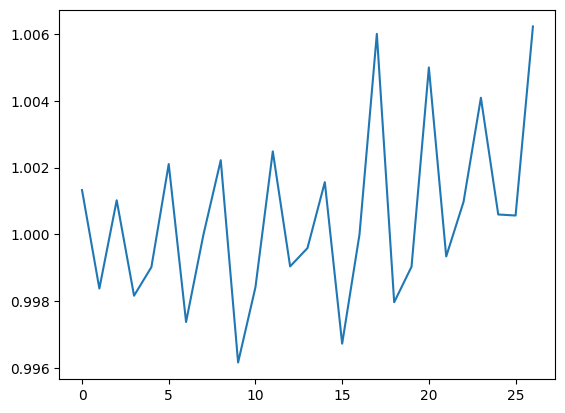

In [159]:
keep = dec.XH[:,-6]>0.5
XH = dec.XH[keep]
ibit = XH[:,-1].astype(int)
H = XH[:,-3]
ubits = np.unique(ibit)
medh = np.array([np.median(H[ibit==bit]) for bit in ubits])
medh = medh/np.median(medh)
#medH_fl = r'Z:\MERFISHp\12_16_2025_BigSlideTest\medHs.npz'
#np.savez(medH_fl,medHs=medh)
import matplotlib.pylab as plt
plt.plot(medh)

In [160]:
# ibit = dec.XH[:,-1].astype(int)
# dec.XH[:,-3]=dec.XH[:,-3]/medh[ibit]

In [161]:
keep = dec.XH[:,-6]>0.5
dec.XH = dec.XH[keep]

In [257]:
get_intersV2(dec,nmin_bits=3,dinstance_th=2)

Calculating lengths of clusters...
Unfolding indexes...


In [258]:
lib_fl = r'Z:\MERFISHp\codebook_BRBB_500Markergn_NewAdaptors.csv'
load_library(dec,lib_fl,nblanks=-1)


In [259]:
get_icodesV3(dec,nmin_bits=3,iH=-3)

Calculating indexes within cluster...
Calculating index of molecule...
Calculating index of first molecule...
Total time unfolded molecules: 1.884413480758667
Computing score...
Total time computing score: 0.05800676345825195
Computing sorting...
Total time sorting molecules by score: 1.1951568126678467
Finding best bits per molecules...
Finding best code...


100%|███████████████████████████████████████████████████████████████████████████████| 752/752 [00:02<00:00, 274.47it/s]


Total time best bits per molecule: 3.5807719230651855


C:\Users\miket\AppData\Local\Temp\ipykernel_15084\45561745.py:11: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  is_bad = np.in1d(dec.icodesN,bad_inds)


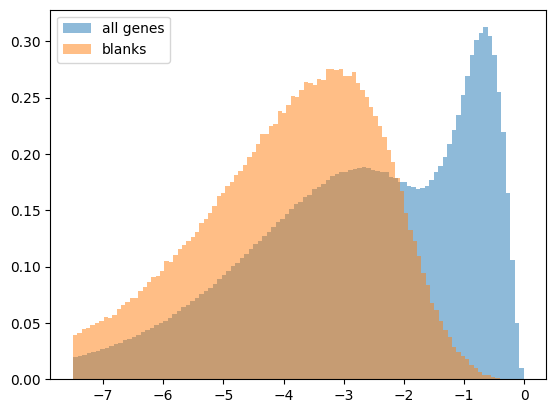

In [260]:
get_score(dec)
score_ref = np.sort(dec.score,axis=0)
dec.score_ref = score_ref
  
set_scoreA(dec)
scoreA = dec.scoreA



bad_inds = [ign for ign,gn in enumerate(dec.gns_names) if 'blank' in gn]
is_bad = np.in1d(dec.icodesN,bad_inds)
is_good_gn = ~is_bad
th_min=-7.5
plt.figure()
kp = scoreA>th_min
plt.hist(scoreA[(is_good_gn)&kp],density=True,bins=100,alpha=0.5,label='all genes')
plt.hist(scoreA[(~is_good_gn)&kp],density=True,bins=100,alpha=0.5,label='blanks');
plt.legend()

In [261]:
def plot_multigenes(self,genes=['Gad1','Sox9'],colors=['r','g','b','m','c','y','w'],smin=3,smax=10,viewer = None,
                    drift=[0,0,0],resc=[1,1,1]):
    icodesN,XH_pruned = self.icodesN,self.XH_pruned
    scoreA=self.scoreA
    th=self.th
    gns_names = list(self.gns_names)
    
    Xcms = np.nanmean(XH_pruned,axis=1)
    keep = scoreA>th
    X = (Xcms[:,:3][keep]-drift)/resc  
    H = scoreA[keep]
    H -= np.min(H)
    icodesf = icodesN[keep]
    size = smin+np.clip(H/np.max(H),0,1)*(smax-smin)
    
    if viewer is None:
        import napari
        viewer = napari.Viewer()
    for igene,gene in enumerate(genes):
        color= colors[igene%len(colors)]
        icode = gns_names.index(gene)
        is_code = icode==icodesf
        viewer.add_points(X[is_code][:,1:],size=size[is_code],face_color=color,name=gene,border_width=0)
        #viewer.layers[-1].visible=False
    return viewer
def plot_statistics(dec):
    if hasattr(dec,'im_segm_'):
        ncells = len(np.unique(dec.im_segm_))-1
    else:
        ncells = 1
    icds,ncds = np.unique(dec.icodesN[dec.scoreA>dec.th],return_counts=True)
    print([str(e)for e in dec.gns_names[icds[np.argsort(ncds)[::-1]]]][:30])
    good_igns = [ign for ign,gn in enumerate(dec.gns_names) if 'blank' not in gn.lower()]
    kp = np.in1d(icds,good_igns)
    ncds = ncds/ncells
    plt.figure()
    plt.xlabel('Genes')
    plt.plot(icds[kp],ncds[kp],label='genes')
    plt.plot(icds[~kp],ncds[~kp],label='blank')
    plt.ylabel('Number of molecules in the fov')
    plt.title(str(np.round(np.mean(ncds[~kp])/np.mean(ncds[kp]),3)))
    plt.yscale('log')
    plt.legend()

['Slc17a7', 'Ptk2b', 'Slc1a3', 'Nfix', 'Sv2b', 'Rgs4', 'Rasgrp1', 'Slc30a3', 'Grm3', 'Lhx2', 'Unc5d', 'Kcnk9', 'Nr2f1', 'Nptx2', 'Cacng3', 'Epha4', 'Fosl2', 'Pdzrn3', 'Slit3', 'Lamp5', 'Caln1', 'Syt17', 'Gpr88', 'Ccn3', 'Pou3f3', 'Sorcs3', 'A830036E02Rik', 'Cxcl14', 'Zeb2', 'Gja1']


C:\Users\miket\AppData\Local\Temp\ipykernel_15084\642500002.py:34: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  kp = np.in1d(icds,good_igns)


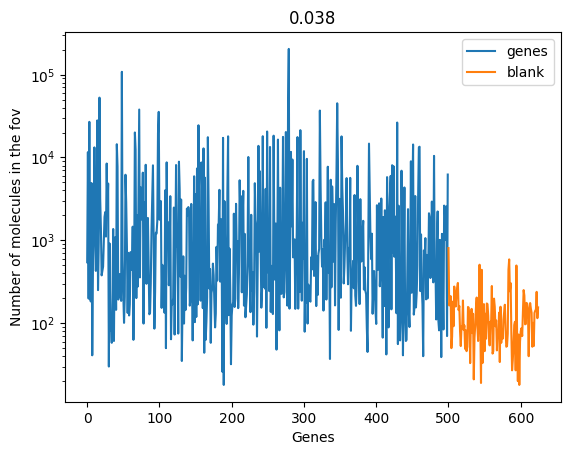

In [262]:
dec.gns_names=np.array(dec.gns_names)
dec.th=-1.5
plot_statistics(dec)

In [263]:
fov='Conv_zscan1__013'
dec.decoded_fl = r'Z:\MERFISHp\12_16_2025_BigSlideTest\decoded_files'+os.sep+f'DecodedNew--{fov}.npz'
scoreA = np.load(dec.decoded_fl)['scoreA']
keep = scoreA>-3
XH_pruned = np.load(dec.decoded_fl)['XH_pruned'][keep]
scoreA = np.load(dec.decoded_fl)['scoreA'][keep]
icodesN = np.load(dec.decoded_fl)['icodesN'][keep]


keep =  dec.scoreA>-3
XH_pruned_full = dec.XH_pruned[keep]
scoreA_full = dec.scoreA[keep]
icodesN_full = dec.icodesN[keep]

keep_gn = dec.gns_names[icodesN]=='Slc17a7'
keep_gn_full = dec.gns_names[icodesN_full]=='Slc17a7'


import napari
V = napari.Viewer()
V.add_points(np.nanmean(XH_pruned_full,axis=1)[keep_gn_full][:,1:3],size=5,face_color='g')
V.add_points(np.nanmean(XH_pruned,axis=1)[keep_gn][:,1:3],size=5,face_color='r')

In [264]:
keep =  dec.scoreA>-3
XH_pruned_full = dec.XH_pruned[keep]
scoreA_full = dec.scoreA[keep]
icodesN_full = dec.icodesN[keep]

In [265]:
keep_gn = dec.gns_names[icodesN]=='Slc17a7'
keep_gn_full = dec.gns_names[icodesN_full]=='Slc17a7'

In [266]:
import napari
V = napari.Viewer()
V.add_points(np.nanmean(XH_pruned_full,axis=1)[keep_gn_full][:,1:3],size=5,face_color='g')
V.add_points(np.nanmean(XH_pruned,axis=1)[keep_gn][:,1:3],size=5,face_color='r')

<Points layer 'Points [1]' at 0x1cd71b2f130>

INFO: Selected 257969 points in this slice, use Shift-A to select all points on the layer. (257969 selected)


In [233]:
plot_multigenes(dec,genes=['Slc17a7',
                           'Slit3','Gja1', 'Slc1a3','Gad2','Lamp5','Megf11','Igfbpl1'])

Viewer(camera=Camera(center=(0.0, np.float64(1405.078468799591), np.float64(1571.285364786784)), zoom=np.float64(0.2175316154274793), angles=(0.0, 0.0, 90.0), perspective=0.0, mouse_pan=True, mouse_zoom=True, orientation=(<DepthAxisOrientation.TOWARDS: 'towards'>, <VerticalAxisOrientation.DOWN: 'down'>, <HorizontalAxisOrientation.RIGHT: 'right'>)), cursor=Cursor(position=(1.0, 1.0), viewbox=None, scaled=True, style=<CursorStyle.STANDARD: 'standard'>, size=1.0), dims=Dims(ndim=2, ndisplay=2, order=(0, 1), axis_labels=('0', '1'), rollable=(True, True), range=(RangeTuple(start=np.float64(2.9297143618265786), stop=np.float64(2806.2330729166665), step=np.float64(1.0)), RangeTuple(start=np.float64(189.23040771484375), stop=np.float64(3077.2926432291665), step=np.float64(1.0))), margin_left=(0.0, 0.0), margin_right=(0.0, 0.0), point=(np.float64(1404.9297143618267), np.float64(1571.2304077148438)), last_used=0), grid=GridCanvas(stride=1, shape=(-1, -1), enabled=False, spacing=0.0), layers=[<Po

C:\Users\miket\AppData\Local\Temp\ipykernel_15084\45561745.py:11: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  is_bad = np.in1d(dec.icodesN,bad_inds)


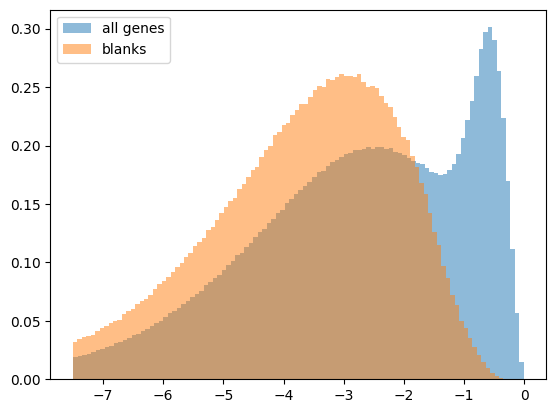

In [189]:
get_score(dec)
score_ref = np.sort(dec.score,axis=0)
dec.score_ref = score_ref
  
set_scoreA(dec)
scoreA = dec.scoreA



bad_inds = [ign for ign,gn in enumerate(dec.gns_names) if 'blank' in gn]
is_bad = np.in1d(dec.icodesN,bad_inds)
is_good_gn = ~is_bad
th_min=-7.5
plt.figure()
kp = scoreA>th_min
plt.hist(scoreA[(is_good_gn)&kp],density=True,bins=100,alpha=0.5,label='all genes')
plt.hist(scoreA[(~is_good_gn)&kp],density=True,bins=100,alpha=0.5,label='blanks');
plt.legend()

### Perform chromatic abberation

In [202]:
XH_pruned = dec.XH_pruned[dec.scoreA>-1] #change this score
color = XH_pruned[:,:,-2]
ucolors=  np.unique(color)
ucolors=ucolors[ucolors>-1]

#align color 0 to color 1

col = 0
col_ref=1

from itertools import combinations
combs = np.array([[i,j] for i in np.arange(color.shape[-1]) for j in np.arange(color.shape[-1])])
color_cmbs = color[:,combs]
X_cmbs = XH_pruned[:,:,:3][:,combs]
#good = ~np.any(np.isnan(color_cmbs),axis=-1)
keep = (color_cmbs[:,:,0]==col_ref)&(color_cmbs[:,:,1]==col)
X1,X2 = X_cmbs[keep].swapaxes(0,1)

# import napari
# V = napari.view_points(X1,face_color='r',size=3,border_width=0)
# V.add_points(X2,face_color='g',size=3,border_width=0)

In [203]:
res = 100
vals = np.round(X1/res).astype(int)*res
difs = X1-X2
dic={}
for val,dif in zip (tqdm(vals),difs):
    key = tuple(val)
    if key not in dic: dic[key]=[]
    dic[key].append(dif)
for key in dic:
    dic[key] = np.mean(dic[key],axis=0)
X1_,D = np.array(list(dic.keys())),np.array(list(dic.values()))
X2_ = X1_-D*10
X1__ = np.concatenate([X1_,X1_+[10,0,0],X1_+[20,0,0],X1_+[30,0,0]])
X2__ = np.concatenate([X2_,X2_+[10,0,0],X2_+[20,0,0],X2_+[30,0,0]])
m = calc_color_matrix(X1__,X2__,order=2)
X2_T = apply_colorcor(X2_,m)
#ms = [m,None]
if True:
    import napari
    V=napari.view_points(X1_[:,1:],face_color='r',size=10)
    V.add_points(X2_[:,1:],face_color='g',size=10)
    V.add_points(X2_T[:,1:],face_color='c',size=10)

100%|████████████████████████████████████████████████████████████████████| 2180888/2180888 [00:02<00:00, 733734.32it/s]
C:\Users\miket\AppData\Local\Temp\ipykernel_15084\3126429708.py:20: FutureWarning: `napari.view_points` is deprecated and will be removed in napari 0.7.0.
Use `viewer = napari.Viewer(); viewer.add_points(...)` instead.
  V=napari.view_points(X1_[:,1:],face_color='r',size=10)


In [192]:
X1_,D = np.array(list(dic.keys())),np.array(list(dic.values()))
X2_ = X1_-D
X1__ = np.concatenate([X1_,X1_+[10,0,0],X1_+[20,0,0],X1_+[30,0,0]])
X2__ = np.concatenate([X2_,X2_+[10,0,0],X2_+[20,0,0],X2_+[30,0,0]])
m = calc_color_matrix(X1__,X2__,order=2)
X2_T = apply_colorcor(X2_,m)
ms = [m,None]
#pickle.dump(ms,open('color_correction_BICAN.pkl','wb'))

In [193]:
XH_pruned = dec.XH_pruned[dec.scoreA>-2]
color = XH_pruned[:,:,-2]
ucolors=  np.unique(color)
ucolors=ucolors[ucolors>-1]


from itertools import combinations
combs = np.array([[i,j] for i in np.arange(color.shape[-1]) for j in np.arange(color.shape[-1])])
color_cmbs = color[:,combs]
X_cmbs = XH_pruned[:,:,:3][:,combs]
#good = ~np.any(np.isnan(color_cmbs),axis=-1)
keep = (color_cmbs[:,:,0]==1)&(color_cmbs[:,:,1]==2)
X1,X2 = X_cmbs[keep].swapaxes(0,1)

res = 100
vals = np.round(X1/res).astype(int)*res
difs = X1-X2
dic={}
for val,dif in zip (tqdm(vals),difs):
    key = tuple(val)
    if key not in dic: dic[key]=[]
    dic[key].append(dif)
for key in dic:
    dic[key] = np.mean(dic[key],axis=0)

X1_,D = np.array(list(dic.keys())),np.array(list(dic.values()))
X2_ = X1_-D
X1__ = np.concatenate([X1_,X1_+[10,0,0],X1_+[20,0,0],X1_+[30,0,0]])
X2__ = np.concatenate([X2_,X2_+[10,0,0],X2_+[20,0,0],X2_+[30,0,0]])
m = calc_color_matrix(X1__,X2__,order=2)
X2_T = apply_colorcor(X2_,m)
msf = ms+[m]

100%|████████████████████████████████████████████████████████████████████| 4290148/4290148 [00:05<00:00, 728623.32it/s]


In [194]:
import pickle
pickle.dump(msf,open(r'Z:\MERFISHp\12_16_2025_BigSlideTest\3color_coorection_Mammoth_afterGlobalPass2.pkl','wb'))

In [196]:
msf1 = pickle.load(open(r'Z:\MERFISHp\12_16_2025_BigSlideTest\3color_coorection_Mammoth_afterGlobalPass1.pkl','rb'))
msf2 = pickle.load(open(r'Z:\MERFISHp\12_16_2025_BigSlideTest\3color_coorection_Mammoth_afterGlobalPass2.pkl','rb'))
msff = []
for m1,m2 in zip(msf1,msf2):
    #m1,m2 = msf1[0],msf2[0]
    #m1: transforms 750 into cy5
    #m2 the remaining 750 into cy5
    #X1 in cy5
    # X2 will be  invm2 on invm1 on X1

    X_Tf1 = apply_colorcor(X1__,m1)
    m1i = calc_color_matrix(X1__,X_Tf1,order=2)

    X_Tf1 = apply_colorcor(X1__,m2)
    m2i = calc_color_matrix(X1__,X_Tf1,order=2)
    
    X2__ = apply_colorcor(apply_colorcor(X1__,m1i),m2i)
    #m = calc_color_matrix(X_Tf2,X1__,order=2)
    m = calc_color_matrix(X1__,X2__,order=2)
    msff.append(m)
msff[1]=None
pickle.dump(msff,open(r'Z:\MERFISHp\12_16_2025_BigSlideTest\3color_coorection_Mammoth_afterGlobalFinal.pkl','wb'))

C:\Users\miket\AppData\Local\Temp\ipykernel_15084\45561745.py:11: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  is_bad = np.in1d(dec.icodesN,bad_inds)


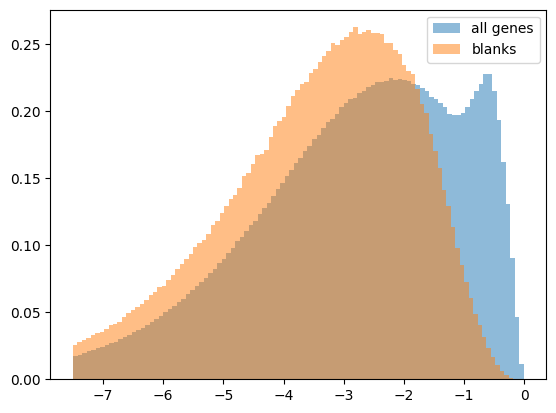

In [41]:
get_score(dec)
score_ref = np.sort(dec.score,axis=0)
dec.score_ref = score_ref
  
set_scoreA(dec)
scoreA = dec.scoreA



bad_inds = [ign for ign,gn in enumerate(dec.gns_names) if 'blank' in gn]
is_bad = np.in1d(dec.icodesN,bad_inds)
is_good_gn = ~is_bad
th_min=-7.5
plt.figure()
kp = scoreA>th_min
plt.hist(scoreA[(is_good_gn)&kp],density=True,bins=100,alpha=0.5,label='all genes')
plt.hist(scoreA[(~is_good_gn)&kp],density=True,bins=100,alpha=0.5,label='blanks');
plt.legend()

In [134]:

import napari
V = napari.Viewer()
X2d = XH[XH[:,-1]==0][:,0:2]
V.add_points(X2d,size=1,border_width=0,face_color=np.random.random(3))
X2d = XH[XH[:,-1]==9][:,0:2]
V.add_points(X2d,size=1,border_width=0,face_color=np.random.random(3))

<Points layer 'X2d [1]' at 0x1cda1b64ac0>

In [46]:
dec.XH  = np.array(dec.XH )

In [49]:
dec.dec.sz[-2:]

[2800, 2800]